In [16]:
import tensorflow.keras.layers as Layers
#import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
import tensorflow.keras.callbacks as Callbacks
#from tensorflow.python.keras.utils.vis_utils import model_to_dot
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.utils import shuffle
#from sklearn.metrics import confusion_matrix as CM
#from random import randint
#from IPython.display import SVG
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)

    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [19]:
train_DIR = "../archive/seg_train/seg_train/"

train_datagen = ImageDataGenerator( rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(train_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

test_DIR = "../archive/seg_test/seg_test/"
validation_datagen = ImageDataGenerator(rescale = 1.0/255)


validation_generator = validation_datagen.flow_from_directory(test_DIR,
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [4]:
Images, Labels = get_images('../archive/seg_train/seg_train/') #Extract the training images from the folders.

# Images = np.array(Images) #converting the list of images to numpy array.
# Labels = np.array(Labels)

In [30]:
test_images, test_labels = get_images('../archive/seg_test/seg_test/')
# test_images = np.array(test_images)
# test_labels = np.array(test_labels)

<BarContainer object of 6 artists>

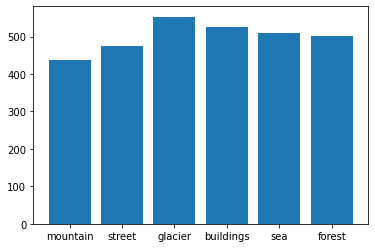

In [33]:
test_counts = np.unique(test_labels)
chart = np.array([test_labels.count(n) for n in test_counts])
plt.bar(class_names,chart)

In [18]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

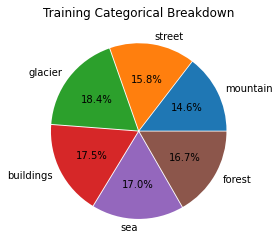

In [35]:
labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
plt.pie(chart,
        explode=(0.01, 0.01, 0.01, 0.01, 0.01, 0.01) , 
        labels=class_names,autopct='%1.1f%%')
# plt.axis('equal')
plt.title('Training Categorical Breakdown')
plt.show()

In [5]:
#get current working directory path + log dir
root_logdir = os.path.join(os.curdir, "my_logs")

#returns a file path of the ending in the current time down to seconds
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [36]:
model_1 = Models.Sequential()

model_1.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(150,150,3), padding="same"))
model_1.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_1.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_1.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_1.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_1.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_1.add(Layers.Flatten())

model_1.add(Layers.Dense(64,activation='relu'))
model_1.add(Layers.Dropout(rate=0.5))
model_1.add(Layers.Dense(32,activation='relu'))

model_1.add(Layers.Dense(6,activation='softmax'))

model_1.compile(optimizer=Optimizer.Adam(lr=0.01),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

print(model_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 23104)             0

In [26]:
run_logdir = get_run_logdir()
tensorboard_cb = Callbacks.TensorBoard(run_logdir)

model_1.fit(Images, Labels, 
                    batch_size=32, 
                    epochs=50, 
                    validation_split = 0.2,
                    callbacks=[tensorboard_cb])

Train on 11227 samples, validate on 2807 samples
Epoch 1/50
11227/11227 [==============================] - 5s 486us/sample - loss: 6.7253 - accuracy: 0.1704 - val_loss: 1.7926 - val_accuracy: 0.1589
Epoch 2/50
11227/11227 [==============================] - 4s 398us/sample - loss: 1.7917 - accuracy: 0.1746 - val_loss: 1.7939 - val_accuracy: 0.1589
Epoch 3/50
11227/11227 [==============================] - 5s 404us/sample - loss: 1.7912 - accuracy: 0.1747 - val_loss: 1.7958 - val_accuracy: 0.1589
Epoch 4/50
11227/11227 [==============================] - 4s 399us/sample - loss: 1.7927 - accuracy: 0.1741 - val_loss: 1.7940 - val_accuracy: 0.1585
Epoch 5/50
11227/11227 [==============================] - 5s 403us/sample - loss: 1.7918 - accuracy: 0.1737 - val_loss: 1.7923 - val_accuracy: 0.1799
Epoch 6/50
11227/11227 [==============================] - 4s 395us/sample - loss: 1.7920 - accuracy: 0.1740 - val_loss: 1.7934 - val_accuracy: 0.1799
Epoch 7/50
11227/11227 [===========================

KeyboardInterrupt: 

In [14]:
model_1.save('saved_model\\3x1_1mil_Relu')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model\3x1_1mil_Relu\assets


In [15]:
model_2 = Models.Sequential()

model_2.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(150,150,3), padding="same"))
model_2.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding="same"))
model_2.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_2.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_2.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_2.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_2.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_2.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_2.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_2.add(Layers.Flatten())

model_2.add(Layers.Dense(64,activation='relu'))
model_2.add(Layers.Dropout(rate=0.5))
model_2.add(Layers.Dense(32,activation='relu'))
model_2.add(Layers.Dropout(rate=0.5))
model_2.add(Layers.Dense(6,activation='softmax'))

model_2.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 38, 38, 64)       

In [16]:
run_logdir = get_run_logdir()
tensorboard_cb = Callbacks.TensorBoard(run_logdir)

model_2.fit(Images, Labels, 
                    batch_size=32, 
                    epochs=50, 
                    validation_split = 0.2,
                    callbacks=[tensorboard_cb])

Train on 11227 samples, validate on 2807 samples
Epoch 1/50
11227/11227 [==============================] - 8s 709us/sample - loss: 1.9935 - accuracy: 0.1766 - val_loss: 1.7917 - val_accuracy: 0.1799
Epoch 2/50
11227/11227 [==============================] - 7s 647us/sample - loss: 1.7922 - accuracy: 0.1789 - val_loss: 1.7916 - val_accuracy: 0.1799
Epoch 3/50
11227/11227 [==============================] - 7s 644us/sample - loss: 1.7914 - accuracy: 0.1789 - val_loss: 1.7916 - val_accuracy: 0.1799
Epoch 4/50
11227/11227 [==============================] - 7s 644us/sample - loss: 1.7912 - accuracy: 0.1788 - val_loss: 1.7916 - val_accuracy: 0.1799
Epoch 5/50
11227/11227 [==============================] - 7s 649us/sample - loss: 1.7911 - accuracy: 0.1788 - val_loss: 1.7916 - val_accuracy: 0.1799
Epoch 6/50
11227/11227 [==============================] - 7s 644us/sample - loss: 1.7910 - accuracy: 0.1788 - val_loss: 1.7916 - val_accuracy: 0.1799
Epoch 7/50
11227/11227 [===========================

In [17]:
model_2.save('saved_model\\3x2_1mil_Relu')

INFO:tensorflow:Assets written to: saved_model\3x2_1mil_Relu\assets


In [18]:
model_3 = Models.Sequential()

model_3.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(150,150,3), padding="same"))
model_3.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding="same"))
model_3.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding="same"))
model_3.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_3.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_3.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_3.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_3.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_3.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_3.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_3.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_3.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_3.add(Layers.Flatten())

model_3.add(Layers.Dense(64,activation='relu'))
model_3.add(Layers.Dropout(rate=0.5))
model_3.add(Layers.Dense(32,activation='relu'))
model_3.add(Layers.Dropout(rate=0.5))
model_3.add(Layers.Dense(6,activation='softmax'))

model_3.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 75, 75, 32)       

In [19]:
run_logdir = get_run_logdir()
tensorboard_cb = Callbacks.TensorBoard(run_logdir)

model_3.fit(Images, Labels, 
                    batch_size=32, 
                    epochs=100, 
                    validation_split = 0.2,
                    callbacks=[tensorboard_cb])

Train on 11227 samples, validate on 2807 samples
Epoch 1/100
11227/11227 [==============================] - 11s 1ms/sample - loss: 1.6693 - accuracy: 0.2565 - val_loss: 1.3761 - val_accuracy: 0.5027
Epoch 2/100
11227/11227 [==============================] - 11s 948us/sample - loss: 1.4949 - accuracy: 0.3400 - val_loss: 1.1979 - val_accuracy: 0.5718
Epoch 3/100
11227/11227 [==============================] - 11s 950us/sample - loss: 1.3845 - accuracy: 0.4120 - val_loss: 1.1022 - val_accuracy: 0.6281
Epoch 4/100
11227/11227 [==============================] - 11s 949us/sample - loss: 1.2916 - accuracy: 0.4575 - val_loss: 0.9787 - val_accuracy: 0.6687
Epoch 5/100
11227/11227 [==============================] - 11s 952us/sample - loss: 1.2108 - accuracy: 0.4856 - val_loss: 0.9328 - val_accuracy: 0.6619
Epoch 6/100
11227/11227 [==============================] - 11s 948us/sample - loss: 1.1611 - accuracy: 0.5098 - val_loss: 0.9432 - val_accuracy: 0.6676
Epoch 7/100
11227/11227 [================

In [20]:
model_3.save('saved_model\\3x3_1mil_Relu')

INFO:tensorflow:Assets written to: saved_model\3x3_1mil_Relu\assets


In [21]:
model_4 = Models.Sequential()

model_4.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(150,150,3), padding="same"))
model_4.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding="same"))
model_4.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_4.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_4.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_4.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_4.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_4.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_4.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_4.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_4.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_4.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))


model_4.add(Layers.Flatten())
model_4.add(Layers.Dense(128,activation='relu'))
model_4.add(Layers.Dropout(rate=0.5))
model_4.add(Layers.Dense(64,activation='relu'))
model_4.add(Layers.Dropout(rate=0.5))
model_4.add(Layers.Dense(32,activation='relu'))
model_4.add(Layers.Dropout(rate=0.5))
model_4.add(Layers.Dense(6,activation='softmax'))

model_4.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 38, 38, 64)       

In [22]:
run_logdir = get_run_logdir()
tensorboard_cb = Callbacks.TensorBoard(run_logdir)

model_4.fit(Images, Labels, 
                    batch_size=32, 
                    epochs=100, 
                    validation_split = 0.2,
                    callbacks=[tensorboard_cb])

Train on 11227 samples, validate on 2807 samples
Epoch 1/100
11227/11227 [==============================] - 9s 817us/sample - loss: 1.8522 - accuracy: 0.2354 - val_loss: 1.7348 - val_accuracy: 0.3587
Epoch 2/100
11227/11227 [==============================] - 8s 717us/sample - loss: 1.7148 - accuracy: 0.2861 - val_loss: 1.6198 - val_accuracy: 0.4282
Epoch 3/100
11227/11227 [==============================] - 8s 716us/sample - loss: 1.6633 - accuracy: 0.3222 - val_loss: 1.6119 - val_accuracy: 0.4275
Epoch 4/100
11227/11227 [==============================] - 8s 717us/sample - loss: 1.6257 - accuracy: 0.3293 - val_loss: 1.5415 - val_accuracy: 0.4407
Epoch 5/100
11227/11227 [==============================] - 8s 716us/sample - loss: 1.5851 - accuracy: 0.3405 - val_loss: 1.4931 - val_accuracy: 0.4435
Epoch 6/100
11227/11227 [==============================] - 8s 715us/sample - loss: 1.5379 - accuracy: 0.3611 - val_loss: 1.4313 - val_accuracy: 0.4418
Epoch 7/100
11227/11227 [====================

In [23]:
model_4.save('saved_model\\4x2_2mil_Relu')

INFO:tensorflow:Assets written to: saved_model\4x2_2mil_Relu\assets


In [24]:
model_5 = Models.Sequential()

model_5.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(150,150,3), padding="same"))
model_5.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding="same"))
model_5.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding="same"))
model_5.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_5.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_5.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_5.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_5.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_5.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_5.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_5.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_5.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_5.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_5.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_5.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_5.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))


model_5.add(Layers.Flatten())
model_5.add(Layers.Dense(128,activation='relu'))
model_5.add(Layers.Dropout(rate=0.5))
model_5.add(Layers.Dense(64,activation='relu'))
model_5.add(Layers.Dropout(rate=0.5))
model_5.add(Layers.Dense(32,activation='relu'))
model_5.add(Layers.Dropout(rate=0.5))
model_5.add(Layers.Dense(6,activation='softmax'))

model_5.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 75, 75, 32)       

In [25]:
run_logdir = get_run_logdir()
tensorboard_cb = Callbacks.TensorBoard(run_logdir)

model_5.fit(Images, Labels, 
                    batch_size=32, 
                    epochs=100, 
                    validation_split = 0.2,
                    callbacks=[tensorboard_cb])

Train on 11227 samples, validate on 2807 samples
Epoch 1/100
11227/11227 [==============================] - 13s 1ms/sample - loss: 1.7094 - accuracy: 0.2556 - val_loss: 1.4314 - val_accuracy: 0.5012
Epoch 2/100
11227/11227 [==============================] - 12s 1ms/sample - loss: 1.5505 - accuracy: 0.3576 - val_loss: 1.2514 - val_accuracy: 0.5322
Epoch 3/100
11227/11227 [==============================] - 12s 1ms/sample - loss: 1.4141 - accuracy: 0.4236 - val_loss: 1.1561 - val_accuracy: 0.5707
Epoch 4/100
11227/11227 [==============================] - 12s 1ms/sample - loss: 1.2929 - accuracy: 0.4884 - val_loss: 0.9778 - val_accuracy: 0.6356
Epoch 5/100
11227/11227 [==============================] - 12s 1ms/sample - loss: 1.2114 - accuracy: 0.5307 - val_loss: 0.9390 - val_accuracy: 0.6131
Epoch 6/100
11227/11227 [==============================] - 12s 1ms/sample - loss: 1.1395 - accuracy: 0.5584 - val_loss: 0.8576 - val_accuracy: 0.6961
Epoch 7/100
11227/11227 [==========================

In [26]:
model_5.save('saved_model\\4x3_2mil_Relu')

INFO:tensorflow:Assets written to: saved_model\4x3_2mil_Relu\assets


In [27]:
model_6 = Models.Sequential()

model_6.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(150,150,3), padding="same"))
model_6.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding="same"))
model_6.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_6.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_6.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_6.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_6.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_6.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_6.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_6.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_6.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_6.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_6.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding="same"))
model_6.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding="same"))
model_6.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_6.add(Layers.Flatten())
model_6.add(Layers.Dense(256,activation='relu'))
model_6.add(Layers.Dropout(rate=0.5))
model_6.add(Layers.Dense(128,activation='relu'))
model_6.add(Layers.Dropout(rate=0.5))
model_6.add(Layers.Dense(64,activation='relu'))
model_6.add(Layers.Dropout(rate=0.5))
model_6.add(Layers.Dense(32,activation='relu'))
model_6.add(Layers.Dropout(rate=0.5))
model_6.add(Layers.Dense(6,activation='softmax'))

model_6.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_6.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 38, 38, 64)       

In [28]:
run_logdir = get_run_logdir()
tensorboard_cb = Callbacks.TensorBoard(run_logdir)

model_6.fit(Images, Labels, 
                    batch_size=32, 
                    epochs=100, 
                    validation_split = 0.2,
                    callbacks=[tensorboard_cb])

Train on 11227 samples, validate on 2807 samples
Epoch 1/100
11227/11227 [==============================] - 10s 911us/sample - loss: 1.8277 - accuracy: 0.1746 - val_loss: 1.7533 - val_accuracy: 0.3274
Epoch 2/100
11227/11227 [==============================] - 9s 785us/sample - loss: 1.7153 - accuracy: 0.2429 - val_loss: 1.5242 - val_accuracy: 0.4507
Epoch 3/100
11227/11227 [==============================] - 9s 786us/sample - loss: 1.6016 - accuracy: 0.3180 - val_loss: 1.3732 - val_accuracy: 0.4913
Epoch 4/100
11227/11227 [==============================] - 9s 785us/sample - loss: 1.4883 - accuracy: 0.3805 - val_loss: 1.2287 - val_accuracy: 0.5358
Epoch 5/100
11227/11227 [==============================] - 9s 783us/sample - loss: 1.3894 - accuracy: 0.4364 - val_loss: 1.1196 - val_accuracy: 0.5525
Epoch 6/100
11227/11227 [==============================] - 9s 786us/sample - loss: 1.2990 - accuracy: 0.4843 - val_loss: 1.0401 - val_accuracy: 0.6067
Epoch 7/100
11227/11227 [===================

In [29]:
model_6.save('saved_model\\5x2_3mil_Relu')

INFO:tensorflow:Assets written to: saved_model\5x2_3mil_Relu\assets


In [7]:
model_7 = Models.Sequential()

model_7.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(150,150,3), padding="same"))
model_7.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_7.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_7.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_7.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_7.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding="same"))
model_7.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_7.add(Layers.Flatten())
model_7.add(Layers.Dense(256,activation='relu'))
model_7.add(Layers.Dropout(rate=0.5))
model_7.add(Layers.Dense(128,activation='relu'))
model_7.add(Layers.Dropout(rate=0.5))
model_7.add(Layers.Dense(64,activation='relu'))
model_7.add(Layers.Dropout(rate=0.5))
model_7.add(Layers.Dense(32,activation='relu'))
model_7.add(Layers.Dropout(rate=0.5))
model_7.add(Layers.Dense(6,activation='softmax'))

model_7.compile(optimizer=Optimizer.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_7.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 75, 75, 32)       

In [9]:
run_logdir = get_run_logdir()
tensorboard_cb = Callbacks.TensorBoard(run_logdir)

model_7.fit(Images, Labels, 
                    batch_size=64, 
                    epochs=100, 
                    validation_split = 0.2,
                    callbacks=[tensorboard_cb])

Train on 11227 samples, validate on 2807 samples
Epoch 1/100
11227/11227 [==============================] - 16s 1ms/sample - loss: 1.7734 - accuracy: 0.2019 - val_loss: 1.7416 - val_accuracy: 0.4254
Epoch 2/100
11227/11227 [==============================] - 14s 1ms/sample - loss: 1.7489 - accuracy: 0.2250 - val_loss: 1.6917 - val_accuracy: 0.4361
Epoch 3/100
11227/11227 [==============================] - 14s 1ms/sample - loss: 1.7282 - accuracy: 0.2382 - val_loss: 1.6237 - val_accuracy: 0.4507
Epoch 4/100
11227/11227 [==============================] - 14s 1ms/sample - loss: 1.6995 - accuracy: 0.2604 - val_loss: 1.6024 - val_accuracy: 0.4564
Epoch 5/100
11227/11227 [==============================] - 14s 1ms/sample - loss: 1.6827 - accuracy: 0.2700 - val_loss: 1.5627 - val_accuracy: 0.4852
Epoch 6/100
11227/11227 [==============================] - 14s 1ms/sample - loss: 1.6566 - accuracy: 0.2909 - val_loss: 1.5109 - val_accuracy: 0.5020
Epoch 7/100
11227/11227 [==========================

In [32]:
model_7.save('saved_model\\5x3_3mil_Relu_lowlern')

INFO:tensorflow:Assets written to: saved_model\5x3_3mil_Relu\assets


In [33]:
model_8 = Models.Sequential()

model_8.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(150,150,3), padding="same"))
model_8.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding="same"))
model_8.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_8.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_8.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_8.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_8.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_8.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_8.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_8.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_8.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding="same"))
model_8.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding="same"))
model_8.add(Layers.Conv2D(384,kernel_size=(3,3),activation='relu', padding="same"))
model_8.add(Layers.Conv2D(384,kernel_size=(3,3),activation='relu', padding="same"))
model_8.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_8.add(Layers.Conv2D(512,kernel_size=(3,3),activation='relu', padding="same"))
model_8.add(Layers.Conv2D(512,kernel_size=(3,3),activation='relu', padding="same"))
model_8.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_8.add(Layers.Flatten())

model_8.add(Layers.Dense(512,activation='relu'))
model_8.add(Layers.Dropout(rate=0.5))

model_8.add(Layers.Dense(384,activation='relu'))
model_8.add(Layers.Dropout(rate=0.5))

model_8.add(Layers.Dense(256,activation='relu'))
model_8.add(Layers.Dropout(rate=0.5))

model_8.add(Layers.Dense(128,activation='relu'))
model_8.add(Layers.Dropout(rate=0.5))

model_8.add(Layers.Dense(64,activation='relu'))
model_8.add(Layers.Dropout(rate=0.5))

model_8.add(Layers.Dense(32,activation='relu'))
model_8.add(Layers.Dropout(rate=0.5))

model_8.add(Layers.Dense(6,activation='softmax'))

model_8.compile(optimizer=Optimizer.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_8.summary()
'''
Largest convolution model, 19Mil params
looks like it starts over fitting around 75 epochs, but valadation accuracy continued to increase
'''

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 150, 150, 32)      4640      
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 75, 75, 64)       

'\nLargest convolution model, 19Mil params\nlooks like it starts over fitting around 75 epochs, but valadation accuracy continued to increase\n'

In [34]:
run_logdir = get_run_logdir()
tensorboard_cb = Callbacks.TensorBoard(run_logdir)

model_8.fit(Images, Labels, 
                    batch_size=32, 
                    epochs=200, 
                    validation_split = 0.2,
                    callbacks=[tensorboard_cb])

=======================] - 49s 4ms/sample - loss: 1.1935 - accuracy: 0.4998 - val_loss: 1.1882 - val_accuracy: 0.5550
Epoch 70/200
11227/11227 [==============================] - 49s 4ms/sample - loss: 1.1859 - accuracy: 0.5027 - val_loss: 1.1707 - val_accuracy: 0.5618
Epoch 71/200
11227/11227 [==============================] - 49s 4ms/sample - loss: 1.1715 - accuracy: 0.5007 - val_loss: 1.1710 - val_accuracy: 0.5590
Epoch 72/200
11227/11227 [==============================] - 49s 4ms/sample - loss: 1.1621 - accuracy: 0.5137 - val_loss: 1.1939 - val_accuracy: 0.5615
Epoch 73/200
11227/11227 [==============================] - 49s 4ms/sample - loss: 1.1553 - accuracy: 0.5087 - val_loss: 1.1722 - val_accuracy: 0.5704
Epoch 74/200
11227/11227 [==============================] - 49s 4ms/sample - loss: 1.1511 - accuracy: 0.5137 - val_loss: 1.1587 - val_accuracy: 0.5586
Epoch 75/200
11227/11227 [==============================] - 49s 4ms/sample - loss: 1.1463 - accuracy: 0.5129 - val_loss: 1.1830

In [35]:
model_8.save('saved_model\\4xMixed_34mil_Relu')

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run Identity: Dst tensor is not initialized. [Op:Identity]

In [8]:
model_9 = Models.Sequential()

model_9.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(150,150,3), padding="same"))
model_9.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_9.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_9.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_9.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_9.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_9.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_9.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_9.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu', padding="same"))
model_9.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_9.add(Layers.Conv2D(384,kernel_size=(3,3),activation='relu', padding="same"))
model_9.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_9.add(Layers.Conv2D(512,kernel_size=(3,3),activation='relu', padding="same"))
model_9.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_9.add(Layers.Flatten())

model_9.add(Layers.Dense(512,activation='relu'))
model_9.add(Layers.Dropout(rate=0.5))
model_9.add(Layers.Dense(384,activation='relu'))
model_9.add(Layers.Dropout(rate=0.5))
model_9.add(Layers.Dense(256,activation='relu'))
model_9.add(Layers.Dropout(rate=0.5))
model_9.add(Layers.Dense(128,activation='relu'))
model_9.add(Layers.Dropout(rate=0.5))
model_9.add(Layers.Dense(64,activation='relu'))
model_9.add(Layers.Dropout(rate=0.5))
model_9.add(Layers.Dense(32,activation='relu'))

model_9.add(Layers.Dense(6,activation='softmax'))

model_9.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_9.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 38, 38, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 19, 19, 128)      

In [9]:
run_logdir = get_run_logdir()
tensorboard_cb = Callbacks.TensorBoard(run_logdir)

model_9.fit(Images, Labels, 
                    batch_size=32, 
                    epochs=200, 
                    validation_split = 0.2,
                    callbacks=[tensorboard_cb])

Train on 11227 samples, validate on 2807 samples
Epoch 1/200
11227/11227 [==============================] - 7s 645us/sample - loss: 1.9871 - accuracy: 0.1680 - val_loss: 1.7905 - val_accuracy: 0.1739
Epoch 2/200
11227/11227 [==============================] - 6s 560us/sample - loss: 1.7977 - accuracy: 0.1721 - val_loss: 1.7899 - val_accuracy: 0.2476
Epoch 3/200
11227/11227 [==============================] - 6s 553us/sample - loss: 1.7905 - accuracy: 0.1734 - val_loss: 1.7721 - val_accuracy: 0.2009
Epoch 4/200
11227/11227 [==============================] - 6s 562us/sample - loss: 1.7257 - accuracy: 0.2242 - val_loss: 1.6532 - val_accuracy: 0.3580
Epoch 5/200
11227/11227 [==============================] - 6s 566us/sample - loss: 1.6288 - accuracy: 0.3077 - val_loss: 1.5264 - val_accuracy: 0.3912
Epoch 6/200
11227/11227 [==============================] - 6s 550us/sample - loss: 1.5455 - accuracy: 0.3358 - val_loss: 1.4634 - val_accuracy: 0.4008
Epoch 7/200
11227/11227 [====================

KeyboardInterrupt: 

In [ ]:
model_9.save('saved_model\\7x1_4mil_Relu')

In [17]:
!tensorboard --logdir=./my_logs --port=6006

^C


In [14]:
model_10 = Models.Sequential()

model_10.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(150,150,3), padding="same"))
model_10.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_10.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_10.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))

model_10.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_10.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding="same"))
model_10.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_10.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_10.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))

model_10.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))

model_10.add(Layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding="same"))
model_10.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding="same"))
model_10.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding="same"))
model_10.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding="same"))
model_10.add(Layers.MaxPool2D((2,2), strides=2, padding="same"))


model_10.add(Layers.Flatten())


model_10.add(Layers.Dense(128,activation='relu'))
model_10.add(Layers.Dropout(rate=0.5))
model_10.add(Layers.Dense(64,activation='relu'))
model_10.add(Layers.Dropout(rate=0.5))
model_10.add(Layers.Dense(32,activation='relu'))
model_10.add(Layers.Dropout(rate=0.5))

model_10.add(Layers.Dense(6,activation='softmax'))

model_10.compile(optimizer=Optimizer.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_10.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 150, 150, 32)      4640      
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 150, 150, 64)      18496     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 150, 150, 128)     73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 75, 75, 16)        18448     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 75, 75, 32)       

In [15]:
run_logdir = get_run_logdir()
tensorboard_cb = Callbacks.TensorBoard(run_logdir)

model_10.fit(Images, Labels, 
                    batch_size=32, 
                    epochs=100, 
                    validation_split = 0.2,
                    callbacks=[tensorboard_cb])

Train on 11227 samples, validate on 2807 samples
Epoch 1/100
 7072/11227 [=================>............] - ETA: 16s - loss: 1.8245 - accuracy: 0.1791

KeyboardInterrupt: 

In [ ]:
model_10.save('saved_model\\4x5mix_8mil_Relu')